In [ ]:
#!pip install diffusers transformers accelerate datasets peft -- upgrade

In [1]:
from datasets import load_dataset
from PIL import Image
import os

In [ ]:
# !huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `colab-lora` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `colab-lora`


In [ ]:
#WAITING ---- FOR ----- ACCESS------
# dataset = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
# save_dir = "/content/pokemon_datasets"
# os.makedirs(save_dir, exist_ok=True)

In [ ]:
#!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.33.0
    Uninstalling huggingface-hub-0.33.0:
      Successfully uninstalled huggingface-hub-0.33.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_s

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# !git lfs install
# !git clone https://huggingface.co/datasets/ppbrown/danbooru-cleaned

Git LFS initialized.
Cloning into 'danbooru-cleaned'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 157 (delta 70), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (157/157), 51.55 KiB | 17.18 MiB/s, done.
Resolving deltas: 100% (70/70), done.
Filtering content: 100% (11/11), 2.95 GiB | 43.54 MiB/s, done.


In [5]:
import os
import zipfile
import glob
from PIL import Image

source_dir = "/content/danbooru-cleaned"
extract_dir = "/content/danbooru-cleaned/extracted"
save_dir = "/content/drive/MyDrive/anime-faces"
#os.makedirs(extract_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

# # Step 1: Extract ZIPs
# zip_files = [f for f in os.listdir(source_dir) if f.endswith(".zip")]

# for zip_name in zip_files:
#     zip_path = os.path.join(source_dir, zip_name)
#     with zipfile.ZipFile(zip_path, "r") as zip_ref:
#         zip_ref.extractall(extract_dir)
#     print(f"✅ Extracted {zip_name}")

# # Step 2: Collect images
# image_paths = glob.glob(f"{extract_dir}/**/*.jpg", recursive=True) + \
#               glob.glob(f"{extract_dir}/**/*.png", recursive=True) + \
#               glob.glob(f"{extract_dir}/**/*.jpeg", recursive=True) + \
#               glob.glob(f"{extract_dir}/**/*.webp", recursive=True)

# print(f"🔍 Found {len(image_paths)} images")

# # Step 3: Save first 100 images to target folder
# for i, path in enumerate(image_paths[:100]):
#     try:
#         img = Image.open(path).convert("RGB")
#         img.save(os.path.join(save_dir, f"image_{i:04d}.png"))
#     except Exception as e:
#         print(f"❌ Failed to process {path}: {e}")

# print(f"✅ Saved {len(os.listdir(save_dir))} images to {save_dir}")


In [6]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import os
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from peft import get_peft_model, LoraConfig

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)


In [9]:
image_folder = "/content//drive/MyDrive/anime-faces"
caption_file = os.path.join(image_folder, "captions.txt")

with open(caption_file, "w") as f:
    for image_name in tqdm(sorted(os.listdir(image_folder))):
        if not image_name.endswith(".png"):
            continue
        image_path = os.path.join(image_folder, image_name)
        image = Image.open(image_path).convert("RGB")

        inputs = processor(images=image, return_tensors="pt").to(device)
        out = model.generate(**inputs)
        caption = processor.decode(out[0], skip_special_tokens=True)

        f.write(f"{image_name}\t{caption}\n")


100%|██████████| 101/101 [01:02<00:00,  1.62it/s]


# Training a LoRa Adapter

In [10]:
import numpy as np
from torch.utils.data import Dataset
class AnimeCaptionDataset(Dataset):
    def __init__(self, image_dir, caption_file, tokenizer, size=512):
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.size = size
        self.data = []

        with open(caption_file, "r") as f:
            for line in f:
                name, caption = line.strip().split("\t")
                self.data.append((name, caption))

        self.transform = transforms.Compose([
            transforms.Resize((size, size), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, caption = self.data[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = self.transform(Image.open(img_path).convert("RGB"))

        # tokenized = self.tokenizer(
        #     caption,
        #     return_tensors="pt",
        #     padding="max_length",
        #     truncation=True,
        #     max_length=77
        # )
        # input_ids = tokenized.input_ids.squeeze(0)

        input_ids = self.tokenizer(
            caption,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        ).input_ids.squeeze(0)

        return {"pixel_values": image, "input_ids": input_ids}

In [11]:
#configuration
image_dir = "/content/drive/MyDrive/anime-faces"
caption_file = "/content/drive/MyDrive/anime-faces/captions.txt"
batch_size = 4
num_epochs = 10

In [12]:
#Load components
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to(device, dtype=torch.float16)
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet", torch_dtype=torch.float16).to(device)
scheduler = DDPMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

In [ ]:
# !pip uninstall -y peft
# !pip install git+https://github.com/huggingface/peft.git


In [13]:
#Apply LoRa config
lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["to_q", "to_k", "to_v"],
    lora_dropout=0.1,
    bias="none",
    #task_type="FEATURE_EXTRACTION"
)
unet = get_peft_model(unet, lora_config)

In [14]:
#Dataset and DataLoader
dataset = AnimeCaptionDataset(image_dir, caption_file, tokenizer)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
#Optimizer
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

In [16]:
# =========================
# Training Loop with proper tensor shapes
# =========================
import torch.nn.functional as F

# =========================
# Fixed Training Loop with PEFT Compatibility
# =========================
for epoch in range(num_epochs):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    total_loss = 0

    for batch in progress_bar:
        pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)
        input_ids = batch["input_ids"].to(device)

        # Create attention mask
        attention_mask = (input_ids != tokenizer.pad_token_id).float()

        with torch.no_grad():
            # Get text embeddings
            text_embeddings = text_encoder(
                input_ids=input_ids,
                attention_mask=attention_mask
            )[0].to(dtype=torch.float16)

            # Encode images
            latents = vae.encode(pixel_values).latent_dist.sample() * 0.18215

        # Sample noise
        noise = torch.randn_like(latents, dtype=torch.float16)
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (latents.shape[0],),
            device=device
        ).long()

        # Add noise
        noisy_latents = scheduler.add_noise(latents, noise, timesteps)

        # Predict noise
        model_pred = unet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=text_embeddings
        ).sample

        # Calculate loss
        loss = F.mse_loss(model_pred.float(), noise.float())

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
        optimizer.step()

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Avg Loss: {total_loss / len(train_loader):.4f}")

Epoch 1: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, loss=0.0122]


Epoch 1, Avg Loss: 0.1159


Epoch 2: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it, loss=0.1035]


Epoch 2, Avg Loss: 0.1453


Epoch 3: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it, loss=0.0185]


Epoch 3, Avg Loss: 0.1416


Epoch 4: 100%|██████████| 25/25 [00:33<00:00,  1.32s/it, loss=0.1274]


Epoch 4, Avg Loss: 0.1063


Epoch 5: 100%|██████████| 25/25 [00:32<00:00,  1.32s/it, loss=0.0996]


Epoch 5, Avg Loss: 0.1313


Epoch 6: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it, loss=0.0751]


Epoch 6, Avg Loss: 0.1357


Epoch 7: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it, loss=0.0996]


Epoch 7, Avg Loss: 0.1204


Epoch 8: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it, loss=0.1005]


Epoch 8, Avg Loss: 0.1503


Epoch 9: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it, loss=0.0555]


Epoch 9, Avg Loss: 0.1040


Epoch 10: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it, loss=0.1061]

Epoch 10, Avg Loss: 0.1032


In [17]:
# #Save model
unet.save_pretrained("/content/drive/MyDrive/lora-anime")
print("✅ Training complete and model saved")

✅ Training complete and model saved


In [2]:
# # Save ONLY the LoRA attention processors (Diffusers-style)
# unet.save_attn_procs("/content/drive/MyDrive/lora-anime")


# Load and Use the LoRA Adapter for prompt Inference

In [20]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from peft import LoraConfig, get_peft_model
import torch

In [21]:
#Load base UNet
unet  = UNet2DConditionModel.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    subfolder="unet",
    torch_dtype=torch.float16
).to("cuda")

In [22]:
#LoRA config as training
lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["to_q", "to_k", "to_v"],
    lora_dropout=0.1,
    bias="none"
)

In [25]:
#Wrao UNET with PEFT
unet= get_peft_model(unet, lora_config)

#Load the trained adapter
unet.load_adapter("/content/drive/MyDrive/lora-anime", adapter_name="default", is_trainable=False)

<All keys matched successfully>

In [26]:
#Load the full stable diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    torch_dtype=torch.float16,
).to("cuda")

pipe.enable_attention_slicing()

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.


In [27]:
#prompt
prompt = "an anime girl with long black hair, blue eyes"

with torch.no_grad():
  image = pipe(
      prompt=prompt,
      num_inference_steps = 30,
      guidance_scale = 7.5,
      height=512,
      width=512,

  ).images[0]


  0%|          | 0/30 [00:00<?, ?it/s]

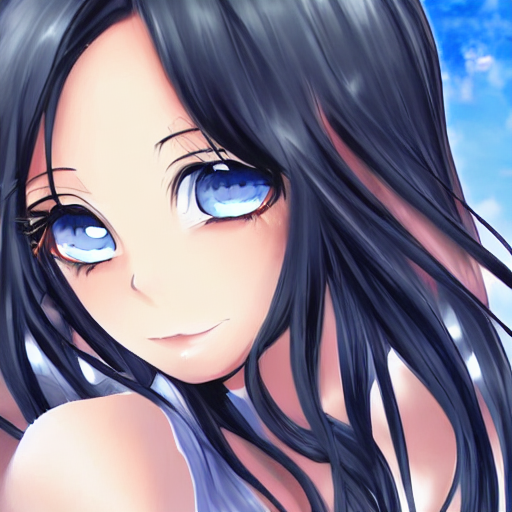

In [28]:
image

In [29]:
image.save("/content/drive/MyDrive/lora-anime/prompt_output1.png")